In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import os, glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv("2008.csv")
print(df.shape)

(7009728, 29)


Dữ liệu gồm 7 triệu bản ghi và 29 thuộc tính.
Một số bản ghi dữ liệu:

In [ ]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


Xem qua các kiểu dữ liệu của các thuộc tính

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [ ]:
df.dtypes.value_counts()

float64    14
int64      10
object      5
dtype: int64

=> Dữ liệu gồm 5 thuộc tính kiểu categorical, 24 thuộc tính kiểu numerical

#### Kiểm tra dữ liệu bị thiếu

In [ ]:
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

#### Xử lý dữ liệu:
<br>
- 6 thuộc tính thiếu khoảng 75% dữ liệu trở lên: 
<br>

* `CancellationCode`: thiếu 98% dữ liệu
* `CarrierDelay`: thiếu 78% dữ liệu
* `WeatherDelay`: thiếu 78% dữ liệu
* `NASDelay`: thiếu 78% dữ liệu
* `SecurityDelay`: thiếu 78% dữ liệu
* `LateAircraftDelay`: thiếu 78% dữ liệu

&emsp;=> Xóa 6 thuộc tính trên

In [3]:
df = df.drop(['CancellationCode','CarrierDelay','WeatherDelay', 'NASDelay','SecurityDelay','LateAircraftDelay'], axis=1)

\- Đối với các thuộc tính khác thiếu khoảng 2% dữ liệu 

&emsp;=> Xóa những dòng bị thiếu dữ liệu

In [4]:
df = df.dropna()
df.shape

(6855024, 23)

\- Đối với thuộc tính `Cancelled` có kiểu dữ liệu nhị phân có ý nghĩa xác định chuyến bay có bị hủy hay không. Trong bài này, ta đi dự đoán một chuyến bay có hạ cánh trễ hay không, do đó chắc chắn chuyến bay đó không bị hủy nên ta có thể bỏ thuộc tính này
<br>
\- Đối với thuộc tính `Year` có giá trị mặc định là 2008 nên ta cũng xóa thuộc tính này. 
<br>

In [5]:
df = df.drop(['Cancelled', 'Year'],axis=1)
df.shape

(6855024, 21)

In [ ]:
df.describe()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Diverted
count,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6855024.0
mean,6.388525e+00,1.573826e+01,3.925802e+00,1.333775e+03,1.325037e+03,1.481265e+03,1.493715e+03,2.212505e+03,1.273224e+02,1.290778e+02,1.040186e+02,8.168407e+00,9.923807e+00,7.287441e+02,6.860150e+00,1.644368e+01,0.0
std,3.398833e+00,8.801085e+00,1.988459e+00,4.780574e+02,4.643130e+02,5.051322e+02,4.826643e+02,1.956435e+03,7.018733e+01,6.953273e+01,6.743981e+01,3.850179e+01,3.520373e+01,5.632449e+02,4.931225e+00,1.131062e+01,0.0
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,-1.410000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.0
25%,3.000000e+00,8.000000e+00,2.000000e+00,9.280000e+02,9.250000e+02,1.107000e+03,1.115000e+03,6.180000e+02,7.700000e+01,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,0.0
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.317000e+03,1.512000e+03,1.515000e+03,1.563000e+03,1.100000e+02,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,0.0
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.728000e+03,1.715000e+03,1.909000e+03,1.905000e+03,3.494000e+03,1.570000e+02,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,0.0
max,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.359000e+03,9.741000e+03,1.379000e+03,6.600000e+02,1.350000e+03,2.461000e+03,2.467000e+03,4.962000e+03,3.080000e+02,4.290000e+02,0.0


=> Sau khi xử lý dữ liệu thiếu, dữ liệu mang toàn bộ giá trị 0 ở thuộc tính Diverted. Do đó t xóa thuộc tính này.

In [6]:
df = df.drop(['Diverted'],axis=1)
df.shape

(6855024, 20)

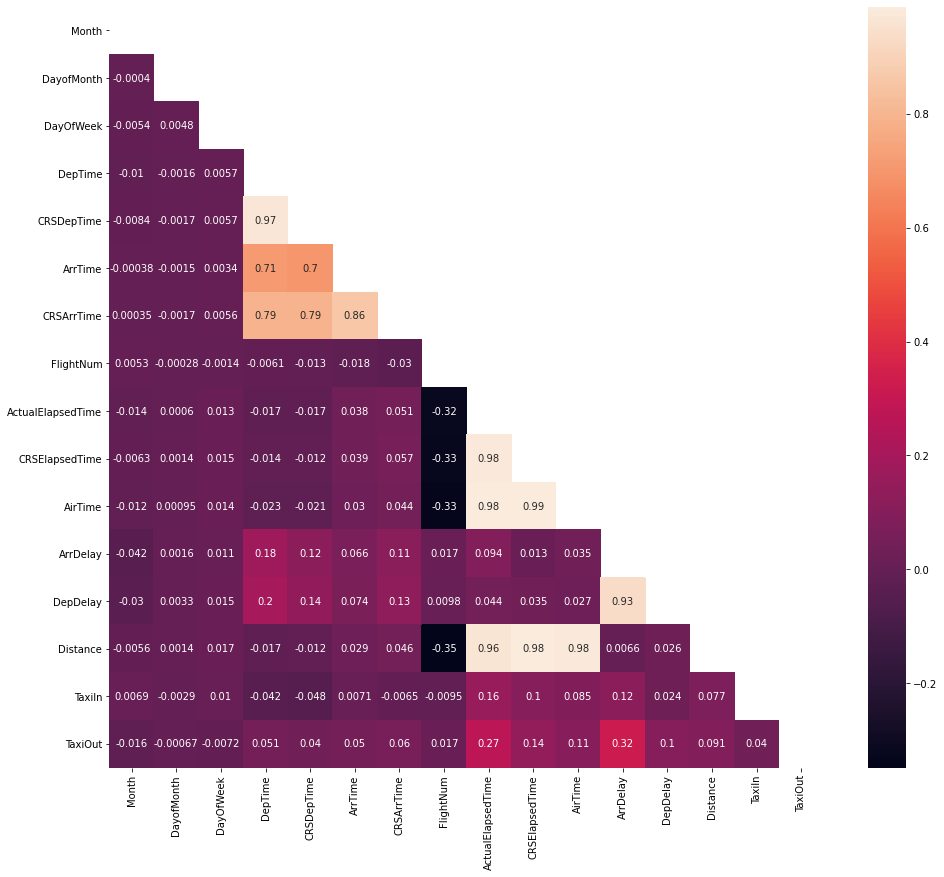

In [ ]:
data = df

fig, ax = plt.subplots(figsize=(16,14)) 
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(data.corr(), mask= mask, ax= ax, annot= True)
plt.show()

In [ ]:
data.corr()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
Month,1.000000,-0.000402,-0.005350,-0.010320,-0.008425,-0.000376,0.000353,0.005307,-0.014061,-0.006346,-0.012413,-0.042058,-0.030498,-0.005558,0.006904,-0.016249
DayofMonth,-0.000402,1.000000,0.004762,-0.001555,-0.001745,-0.001505,-0.001744,-0.000284,0.000598,0.001384,0.000950,0.001605,0.003297,0.001363,-0.002934,-0.000675
DayOfWeek,-0.005350,0.004762,1.000000,0.005660,0.005666,0.003376,0.005569,-0.001438,0.012929,0.015013,0.013915,0.010557,0.015424,0.016730,0.010243,-0.007206
DepTime,-0.010320,-0.001555,0.005660,1.000000,0.968550,0.713081,0.791431,-0.006074,-0.017070,-0.013684,-0.023170,0.178274,0.201981,-0.016523,-0.042255,0.050649
CRSDepTime,-0.008425,-0.001745,0.005666,0.968550,1.000000,0.697293,0.790820,-0.012512,-0.017184,-0.011775,-0.021086,0.116894,0.138850,-0.012189,-0.047563,0.039827
ArrTime,-0.000376,-0.001505,0.003376,0.713081,0.697293,1.000000,0.862455,-0.017674,0.037625,0.038654,0.030320,0.066020,0.073539,0.029023,0.007131,0.049582
CRSArrTime,0.000353,-0.001744,0.005569,0.791431,0.790820,0.862455,1.000000,-0.029613,0.051469,0.056582,0.044016,0.113087,0.132824,0.046195,-0.006540,0.059792
FlightNum,0.005307,-0.000284,-0.001438,-0.006074,-0.012512,-0.017674,-0.029613,1.000000,-0.319347,-0.326568,-0.334444,0.016601,0.009832,-0.348495,-0.009481,0.016576
ActualElapsedTime,-0.014061,0.000598,0.012929,-0.017070,-0.017184,0.037625,0.051469,-0.319347,1.000000,0.979875,0.984241,0.093926,0.044380,0.964521,0.158444,0.267801
CRSElapsedTime,-0.006346,0.001384,0.015013,-0.013684,-0.011775,0.038654,0.056582,-0.326568,0.979875,1.000000,0.988173,0.012642,0.035357,0.983176,0.104174,0.143128


In [7]:
# Xóa feature DepDelay tương quan mạnh với biến target
df = df.drop(['DepDelay'], axis=1)

In [9]:
data = df
corr_mtx = data.corr().abs()
avg_corr = corr_mtx.mean(axis=1)

In [10]:
up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape),k=1).astype(np.bool))

lst = np.empty((0,2),dtype='object')
for row in range(len(up)-1):
    col_idx = row + 1
    
    for col in range(col_idx, len(up)):
        if corr_mtx.iloc[row,col] > 0.9:
            lst = np.append(lst, np.array([[row,col]]),axis=0)
 
print(lst)

[[3 4]
 [8 9]
 [8 10]
 [8 12]
 [9 10]
 [9 12]
 [10 12]]


In [11]:
target_col = corr_mtx.columns.get_loc("ArrDelay")

drop = list()

for pair in lst:
    print(corr_mtx.iloc[pair[0],target_col], corr_mtx.iloc[pair[1],target_col])
    if corr_mtx.iloc[pair[0],target_col] < corr_mtx.iloc[pair[1],target_col]:
        drop.append(pair[0])
    else:
        drop.append(pair[1])

print(list(corr_mtx.columns[[item for item in set(drop)]]))

0.1782743918046631 0.11689447363089882
0.09392577284504985 0.012641789425111485
0.09392577284504985 0.03473299945386927
0.09392577284504985 0.00655151820680346
0.012641789425111485 0.03473299945386927
0.012641789425111485 0.00655151820680346
0.03473299945386927 0.00655151820680346
['CRSElapsedTime', 'AirTime', 'CRSDepTime', 'Distance']


In [10]:
data = data.drop(['CRSElapsedTime', 'AirTime', 'CRSDepTime', 'Distance'], axis=1)
data.shape

(6855024, 15)

In [ ]:
print(df.UniqueCarrier.value_counts())
print(df.TailNum.value_counts())
print(df.Dest.value_counts())
print(df.Origin.value_counts())

WN    1186911
AA     585485
OO     553412
MQ     471161
US     446086
DL     443934
UA     437979
XE     363414
NW     344110
CO     293855
EV     274867
FL     258713
9E     254320
YV     245131
B6     192114
OH     190692
AS     148492
F9      95384
HA      61212
AQ       7752
Name: UniqueCarrier, dtype: int64
N476HA    4701
N477HA    4546
N484HA    4504
N475HA    4496
N480HA    4416
          ... 
N263MQ       1
N78008       1
N27015       1
N298MQ       1
N853NW       1
Name: TailNum, Length: 5366, dtype: int64
ATL    406744
ORD    333331
DFW    272435
DEN    238102
LAX    212371
        ...  
GST        83
BJI        74
INL        71
TUP         9
PIR         5
Name: Dest, Length: 302, dtype: int64
ATL    407701
ORD    334529
DFW    273374
DEN    238191
LAX    212294
        ...  
BJI        73
INL        71
TUP        10
PIR         5
PUB         2
Name: Origin, Length: 303, dtype: int64


In [11]:
df = pd.get_dummies(df, columns=['UniqueCarrier'])

lb_make = LabelEncoder()
df['Origin_code'] = lb_make.fit_transform(df['Origin'])
df['Dest_code'] = lb_make.fit_transform(df['Dest'])
df['TailNum_code'] =  lb_make.fit_transform(df['TailNum'])

df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,TailNum,ActualElapsedTime,...,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,Origin_code,Dest_code,TailNum_code
0,1,3,4,2003.0,1955,2211.0,2225,335,N712SW,128.0,...,0,0,0,0,1,0,0,135,284,3761
1,1,3,4,754.0,735,1002.0,1000,3231,N772SW,128.0,...,0,0,0,0,1,0,0,135,284,4121
2,1,3,4,628.0,620,804.0,750,448,N428WN,96.0,...,0,0,0,0,1,0,0,140,48,1953
3,1,3,4,926.0,930,1054.0,1100,1746,N612SW,88.0,...,0,0,0,0,1,0,0,140,48,3051
4,1,3,4,1829.0,1755,1959.0,1925,3920,N464WN,90.0,...,0,0,0,0,1,0,0,140,48,2134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009723,12,13,6,1002.0,959,1204.0,1150,1636,N646DL,122.0,...,0,0,0,0,0,0,0,18,135,3298
7009724,12,13,6,834.0,835,1021.0,1023,1637,N908DL,167.0,...,0,0,0,0,0,0,0,18,249,4793
7009725,12,13,6,655.0,700,856.0,856,1638,N671DN,121.0,...,0,0,0,0,0,0,0,215,18,3499
7009726,12,13,6,1251.0,1240,1446.0,1437,1639,N646DL,115.0,...,0,0,0,0,0,0,0,135,18,3298


In [12]:
data = df.drop(['TailNum','Origin','Dest'],axis=1)

In [13]:
target = data.ArrDelay.apply(lambda x: 0 if x < 30 else 1)
data = data.drop(['ArrDelay'],axis=1)
data.shape

(6855024, 37)

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_naive_train, X_naive_test, Y_naive_train, Y_naive_test =train_test_split(data,target, test_size=0.3, random_state = 10)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.91      0.75      0.83   1185495
           1       0.25      0.53      0.34    185510

    accuracy                           0.72   1371005
   macro avg       0.58      0.64      0.58   1371005
weighted avg       0.82      0.72      0.76   1371005



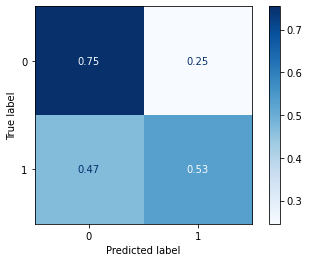

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_naive_train,Y_naive_train)
Y_naive_predict=gnb.predict(X_naive_test)
from sklearn.metrics import classification_report
print(classification_report(Y_naive_test, Y_naive_predict ))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(y_true, y_pred)
plot_confusion_matrix(gnb, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()  

#### Select KBest 

In [ ]:
clf = GaussianNB()
pp_naivebayes_clf = Pipeline([('k_best', SelectKBest(score_func=chi2, k=10)),('nb_clf', clf)])
pp_naivebayes_clf.fit(X_naive_train, Y_naive_train)
y_kbest_pred = pp_naivebayes_clf.predict(X_naive_test)
print(classification_report(Y_naive_test, y_kbest_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89   1185495
           1       0.34      0.38      0.36    185510

    accuracy                           0.82   1371005
   macro avg       0.62      0.63      0.63   1371005
weighted avg       0.83      0.82      0.82   1371005



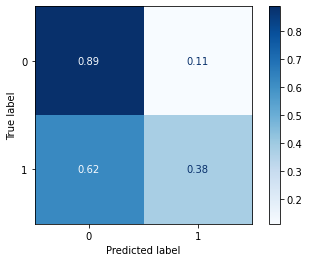

In [ ]:
plot_confusion_matrix(pp_naivebayes_clf, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()  

#### RFE features selection

              precision    recall  f1-score   support

           0       0.91      0.75      0.83   1185495
           1       0.25      0.53      0.34    185510

    accuracy                           0.72   1371005
   macro avg       0.58      0.64      0.58   1371005
weighted avg       0.82      0.72      0.76   1371005



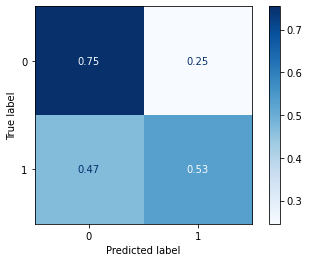

In [ ]:
pp_naivebayes_clf_rfe = Pipeline([('rfe', RFE(clf, 100)),
                           ('nb_clf', clf)])
pp_naivebayes_clf_rfe.fit(X_naive_train, Y_naive_train)
y_rfe_pred = pp_naivebayes_clf_rfe.predict(X_naive_test)
print(classification_report(Y_naive_test, y_rfe_pred))

plot_confusion_matrix(pp_naivebayes_clf_rfe, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()  

### Logistic Regression

              precision    recall  f1-score   support

           0       0.93      1.00      0.96   1185495
           1       0.98      0.52      0.68    185510

    accuracy                           0.93   1371005
   macro avg       0.96      0.76      0.82   1371005
weighted avg       0.94      0.93      0.92   1371005



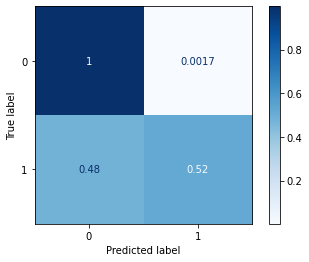

In [ ]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=1000)
logReg.fit(X_naive_train,Y_naive_train)

Y_log_pred=logReg.predict(X_naive_test)
print(classification_report(Y_naive_test, Y_log_pred))

plot_confusion_matrix(logReg, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

### KBest Selection

In [ ]:
logReg = LogisticRegression(max_iter=1000)
pp_logReg_clf = Pipeline([('k_best', SelectKBest(score_func=chi2, k=25)),('log_clf', logReg)])
pp_logReg_clf.fit(X_naive_train, Y_naive_train)
y_kbest_logReg_pred = pp_logReg_clf.predict(X_naive_test)
print(classification_report(Y_naive_test, y_kbest_logReg_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96   1185495
           1       0.96      0.46      0.62    185510

    accuracy                           0.92   1371005
   macro avg       0.94      0.73      0.79   1371005
weighted avg       0.93      0.92      0.91   1371005



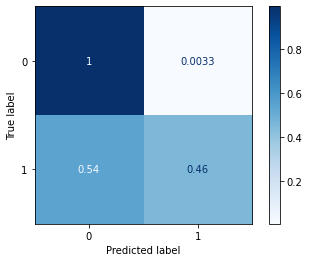

In [ ]:
plot_confusion_matrix(pp_logReg_clf, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### RFE features selection

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.93      1.00      0.96   1185495
           1       0.99      0.50      0.66    185510

    accuracy                           0.93   1371005
   macro avg       0.96      0.75      0.81   1371005
weighted avg       0.94      0.93      0.92   1371005



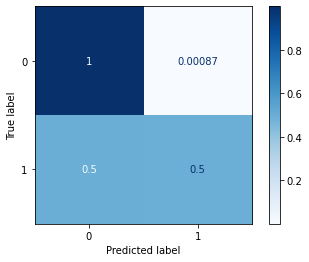

In [ ]:
pp_logReg_clf_rfe = Pipeline([('rfe', RFE(LogisticRegression(max_iter=1000))),
                           ('logReg', LogisticRegression())])
pp_logReg_clf_rfe.fit(X_naive_train, Y_naive_train)
y_rfe_pred = pp_logReg_clf_rfe.predict(X_naive_test)
print(classification_report(Y_naive_test, y_rfe_pred))

plot_confusion_matrix(pp_logReg_clf_rfe, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

### RandomForest



              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1185495
           1       0.98      0.89      0.94    185510

    accuracy                           0.98   1371005
   macro avg       0.98      0.95      0.96   1371005
weighted avg       0.98      0.98      0.98   1371005



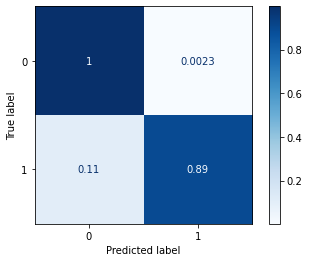

In [ ]:
RF=RandomForestClassifier()
RF.fit(X_naive_train,Y_naive_train)

Y_RF_pred=RF.predict(X_naive_test)
print(classification_report(Y_naive_test, Y_RF_pred))
plot_confusion_matrix(RF, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### SelectKBest

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1185495
           1       0.92      0.15      0.26    185510

    accuracy                           0.88   1371005
   macro avg       0.90      0.57      0.60   1371005
weighted avg       0.89      0.88      0.84   1371005



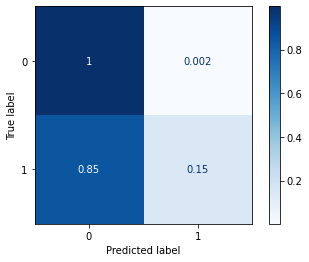

In [ ]:

pp_ranforest_clf = Pipeline([('k_best', SelectKBest(score_func=chi2, k=10)),
                           ('forest_clf',RandomForestClassifier(max_depth=4))])
pp_ranforest_clf.fit(X_naive_train, Y_naive_train)
y_RF_pred = pp_ranforest_clf.predict(X_naive_test)
print(classification_report(Y_naive_test, y_RF_pred))

plot_confusion_matrix(pp_ranforest_clf, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### RFE Feature selection

In [ ]:
pp_ranforest_clf_1 = Pipeline([('rfe', RFE(RandomForestClassifier())), ('forest_clf',RandomForestClassifier())])

pp_ranforest_clf_1.fit(X_naive_train, Y_naive_train)
y_RF_pred_1 = pp_ranforest_clf_1.predict(X_naivi_test)
print(classification_report(y_naive_test, y_RF_pred_1))

plot_confusion_matrix(pp_ranforest_clf_1, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

### GradientBossting

In [ ]:

GB=GradientBoostingClassifier()
GB.fit(X_naive_train,Y_naive_train)

Y_GB_pred=GB.predict(X_naive_test)
print(classification_report(Y_naive_test, Y_GB_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96   1185495
           1       0.96      0.51      0.66    185510

    accuracy                           0.93   1371005
   macro avg       0.94      0.75      0.81   1371005
weighted avg       0.93      0.93      0.92   1371005



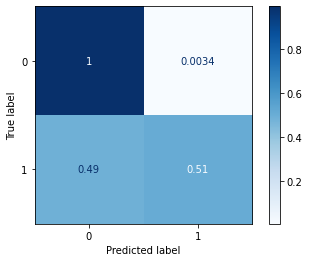

In [ ]:
plot_confusion_matrix(GB, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### Select KBest

In [ ]:
pp_GB_clf = Pipeline([('k_best', SelectKBest(score_func=chi2)),
                      ('GB_clf', GradientBoostingClassifier())])

pp_GB_clf.fit(X_naive_train, Y_naive_train)
y_GB_pred = pp_GB_clf.predict(X_naive_test)

print(classification_report(Y_naive_test, y_GB_pred))

plot_confusion_matrix(pp_GB_clf, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### RFE Feature Selection

In [ ]:
pp_GB_clf_1 = Pipeline([('rfe', RFE(GradientBoostingClassifier(),)),
                        ('GD_clf', GradientBoostingClassifier())])

pp_GB_clf_1.fit(X_naive_train, Y_naive_train)
y_GB_pred_1 = pp_GB_clf_1.predict(X_naive_test)

print(classification_report(Y_naive_test, y_GB_pred_1))

plot_confusion_matrix(pp_GB_clf_1, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

### Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1185495
           1       0.97      0.97      0.97    185510

    accuracy                           0.99   1371005
   macro avg       0.98      0.98      0.98   1371005
weighted avg       0.99      0.99      0.99   1371005



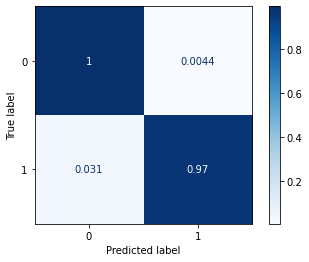

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_naive_train,Y_naive_train)

Y_dt_pred=dtc.predict(X_naive_test)
print(classification_report(Y_naive_test, Y_dt_pred))

plot_confusion_matrix(dtc, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### Select KBest

In [ ]:
pp_tree_clf = Pipeline([('k_best', SelectKBest(score_func=chi2)),
                        ('tree_clf', tree.DecisionTreeClassifier())])

pp_tree_clf.fit(X_naive_train, Y_naive_train)
y_dt_pred = pp_tree_clf.predict(X_naive_test)
print(classification_report(Y_naive_test, y_dt_pred))

plot_confusion_matrix(pp_tree_clf, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

#### RFE feature selection

In [ ]:
pp_tree_clf_rfe = Pipeline([('rfe', RFE(DecisionTreeClassifier(), )),
                           ('DT_clf', tree.DecisionTreeClassifier())])

pp_tree_clf_rfe.fit(X_naive_train, Y_naive_test)
y_dt_tre_pred = pp_tree_clf_rfe.predict(X_naive_test)

print(classification_report(Y_naive_test, y_dt_tre_pred))

plot_confusion_matrix(pp_tree_clf_rfe, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

### SVM

In [ ]:
from sklearn import svm

SVM = svm.SVC(verbose=True)
SVM.fit(X_naive_train,Y_naive_train)

Y_SVM_pred=SVM.predict(X_naive_test)
print(classification_report(Y_naive_test, Y_SVM_pred))

plot_confusion_matrix(SVM, X_naive_test, Y_naive_test,cmap=plt.cm.Blues, normalize='true') 
plt.show()

[LibSVM]

In [ ]:
# criterion param: use 'gini' as default
# splitter param: use 'best' as default
max_depth = [2,4,6,8,10,12]
max_depth.append(None)
min_samples_split=[int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_leaf=[int(x) for x in np.linspace(start = 1, stop = 4, num = 4)]
max_features=['auto', 'sqrt']

# Create the random grid
param_grid = {'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             }

# Initialize and fit the model.
model = DecisionTreeClassifier()
model = GridSearchCV(model, param_grid, n_jobs=-1, verbose=2)
model.fit(X_train_sample, y_train_sample)